In [5]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json

In [1]:
basedir = 'C:/Users/tmhnguyen/Documents/lalamove/lalamove/data/Clean_extracted_240115_uncal/train'
labels = [5, 6, 7]
with open(basedir + '/../data_split_params.json', 'r') as file:
    features = json.load(file)['FEATURES']
print(features)

FileNotFoundError: [Errno 2] No such file or directory: 'D:/lalamove/lalamove/data/Clean_extracted_240115_uncal/train/../data_split_params.json'

In [7]:
label = 5

In [8]:
y = pd.read_csv(basedir + f'/{label}/train_label_{label}.csv')
X = []
step = 30_000
for i in range(np.ceil(len(y)/30_000).astype(int)):
    temp = pd.read_csv(basedir + f'/{label}/extract_features_{label}_{i}.csv', index_col=0)
    X.append(temp)
X = pd.concat(X)
assert len(X) == len(y), f"Length mismatch {len(X)}, {len(y)}"

In [9]:
X.shape, y.shape

((381607, 500), (381607, 6))

In [10]:
dates = y.date.unique()
chosen = dates[-3]
test_idx = y[(y.date == chosen) & (y.type == 0)].index
train_idx = y[(y.date != chosen) & (y.type == 0)]
train_idx_add = y[(y.date != chosen) & (y.type == 1)].sample(frac=0.8)
train_idx = pd.concat([train_idx, train_idx_add]).index
# train_idx = y[(y.date != chosen)].index

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx].label, y.iloc[test_idx].label

In [11]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Conv1D, Dense, Normalization, Activation, GlobalAveragePooling1D, Dropout

In [30]:
class MinMaxScalerLayer(tf.keras.layers.Layer):
    def __init__(self, feature_range=(0, 1), **kwargs):
        super(MinMaxScalerLayer, self).__init__(**kwargs)
        self.feature_range = feature_range
        self.data_min = None
        self.data_max = None
        self.trainable = False # turn off parameter training

    def adapt(self, data):
        data = tf.convert_to_tensor(data)
        self.data_min = tf.math.reduce_min(data, axis=0)
        self.data_max = tf.math.reduce_max(data, axis=0)

    def call(self, inputs):
        if self.data_min is None or self.data_max is None:
            raise RuntimeError("The layer has not been adapted. Call 'adapt' before using the layer.")
        
        inputs = tf.cast(inputs, dtype=tf.float32)
        scaled_data = (inputs - tf.cast(self.data_min, dtype=tf.float32)) / (tf.cast(self.data_max, dtype=tf.float32) - tf.cast(self.data_min, dtype=tf.float32))
        return self.feature_range[0] + (scaled_data * (self.feature_range[1] - self.feature_range[0]))

    def get_config(self):
        config = super(MinMaxScalerLayer, self).get_config()
        config.update({
            "feature_range": self.feature_range
        })
        return config

In [31]:
X_train.shape
scaler = MinMaxScalerLayer()
scaler.adapt(X_test)
scaler(X_train)

<tf.Tensor: shape=(337124, 500), dtype=float32, numpy=
array([[6.6215014e-01, 7.1480137e-01, 4.1456136e-01, ..., 4.7446839e-03,
        7.1756961e-04, 0.0000000e+00],
       [6.2705481e-01, 7.2379255e-01, 4.2752954e-01, ..., 2.7130215e-04,
        1.4026224e-03, 0.0000000e+00],
       [6.3288945e-01, 7.3962891e-01, 4.3872488e-01, ..., 4.0799091e-03,
        1.6787131e-03, 0.0000000e+00],
       ...,
       [4.9085650e-01, 7.0254415e-01, 4.5795515e-01, ..., 1.4087968e-02,
        1.7662533e-03, 0.0000000e+00],
       [6.1214775e-01, 6.1115521e-01, 4.6991280e-01, ..., 4.6141140e-02,
        7.0993200e-02, 1.5922839e-28],
       [6.0057068e-01, 8.6584002e-01, 5.0579190e-01, ..., 3.6392378e-04,
        3.7307480e-05, 0.0000000e+00]], dtype=float32)>

In [32]:
def create_model(xtrain, input_shape=500):
    inputs = Input(shape=input_shape)
    scaler = Normalization()
    scaler.adapt(xtrain)
    scaled_inputs = scaler(inputs)
    x = Dense(500, activation='relu')(scaled_inputs)
    x = Dense(100, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(100, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(100, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(100, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(50, activation='relu')(x)
    output = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=inputs, outputs=output)
    return model

In [33]:
model = create_model(X_train, input_shape=X_train.shape[1])

model.compile(optimizer=Adam(learning_rate=2e-5),
              loss='binary_crossentropy',
              metrics=[BinaryAccuracy(name='acc'),
                       Precision(name='precision'),
                       Recall(name='recall')])

history = model.fit(X_train, y_train, batch_size=256, epochs=30, validation_data=(X_test, y_test),)
                    # callbacks=[EarlyStopping(patience=5,
                    #                    min_delta=0.0005,
                    #                    restore_best_weights=True)])

Epoch 1/30
1317/1317 [==============================] - 5s 3ms/step - loss: 0.2934 - acc: 0.8697 - precision: 0.9192 - recall: 0.5915 - val_loss: 0.1137 - val_acc: 0.9694 - val_precision: 0.0640 - val_recall: 0.0412
Epoch 2/30
1317/1317 [==============================] - 4s 3ms/step - loss: 0.1085 - acc: 0.9677 - precision: 0.9711 - recall: 0.9131 - val_loss: 0.1085 - val_acc: 0.9730 - val_precision: 0.0526 - val_recall: 0.0225
Epoch 3/30
1317/1317 [==============================] - 4s 3ms/step - loss: 0.0912 - acc: 0.9727 - precision: 0.9798 - recall: 0.9225 - val_loss: 0.0960 - val_acc: 0.9770 - val_precision: 0.0566 - val_recall: 0.0112
Epoch 4/30
1317/1317 [==============================] - 4s 3ms/step - loss: 0.0826 - acc: 0.9749 - precision: 0.9826 - recall: 0.9277 - val_loss: 0.1097 - val_acc: 0.9720 - val_precision: 0.0472 - val_recall: 0.0225
Epoch 5/30
1317/1317 [==============================] - 4s 3ms/step - loss: 0.0773 - acc: 0.9763 - precision: 0.9837 - recall: 0.9317 - 

427/427 [==============================] - 0s 732us/step
(13649, 1) (13649,)
type
True Positive        10
True Negative     13281
False Positive      101
False Negative      257
Name: count, dtype: int64


Text(0.5, 1.0, "['z_gyro_clean', 'y_gyro_clean', 'x_gyro_clean', 'x_acc_clean', 'y_acc_clean', 'z_acc_clean', 'acceleration', 'speed_kmh']")

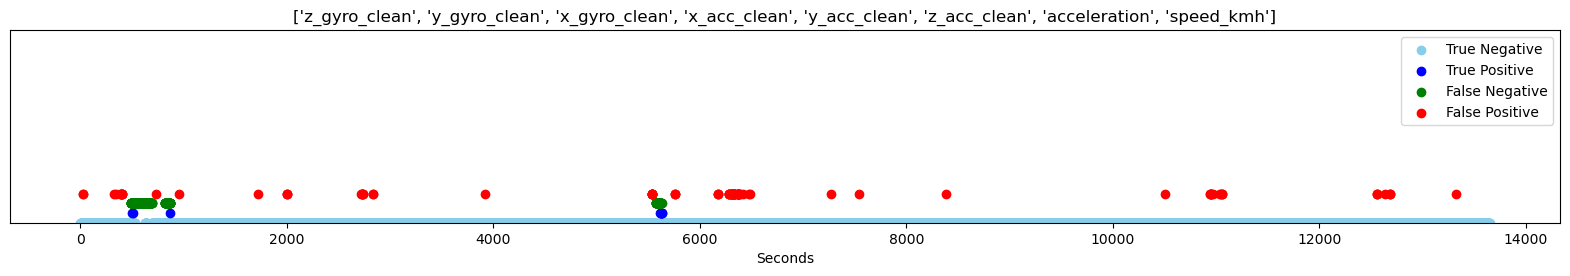

In [34]:
pred = model.predict(X_test) >= 0.5
print(pred.shape, y_test.shape)

df = pd.DataFrame(np.hstack((y_test.to_numpy().reshape(-1, 1), pred)), columns=['true', 'pred'])
df.pred = df.pred.astype(int)

def classify(row):
    true, pred = row.true, row.pred
    if true == pred and true == 0:
        return 'True Negative'
    elif true == pred and true == 1:
        return 'True Positive'
    elif true != pred and true == 0:
        return 'False Positive'
    else:
        return 'False Negative'
    
df['type'] = df.apply(lambda x: classify(x), axis=1)
types = df.type.value_counts().sort_index()[::-1]
print(types)

fig, ax = plt.subplots(figsize=(20, 2.5))
i = 0
colors = ['skyblue', 'blue', 'green', 'red']
types_ = ['True Negative', 'True Positive', 'False Negative', 'False Positive']

for j, t in enumerate(types_):
    ax.scatter(df[df.type==t].index, [i]*types[t], label=t, c=colors[j])
    i += 0.1

ax.legend()
ax.set_ylim(0, 2)
ax.set_xlabel('Seconds')
ax.get_yaxis().set_visible(False)
ax.set_title(f'{features[str(label)]}')


427/427 [==============================] - 0s 721us/step
(13649,) (13649,)
(13649,) (13649,)
type
True Positive         4
True Negative     13317
False Positive       65
False Negative      263
Name: count, dtype: int64


Text(0.5, 1.0, "['z_gyro_clean', 'y_gyro_clean', 'x_gyro_clean', 'x_acc_clean', 'y_acc_clean', 'z_acc_clean', 'acceleration', 'speed_kmh']")

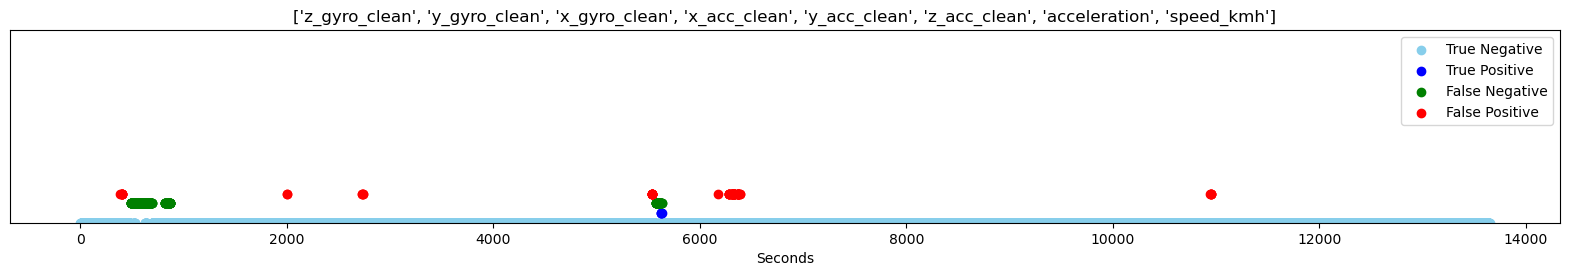

In [35]:
pred = model.predict(X_test).flatten() 
print(pred.shape, y_test.shape)
w = 5 # window in seconds
pred = np.convolve(pred, np.ones(w), mode='same') / w >= 0.5

print(pred.shape, y_test.shape)
df = pd.DataFrame(np.stack((y_test, pred)).T, columns=['true', 'pred'])
df.pred = df.pred.astype(int)

def classify(row):
    true, pred = row.true, row.pred
    if true == pred and true == 0:
        return 'True Negative'
    elif true == pred and true == 1:
        return 'True Positive'
    elif true != pred and true == 0:
        return 'False Positive'
    else:
        return 'False Negative'
    
df['type'] = df.apply(lambda x: classify(x), axis=1)
types = df.type.value_counts().sort_index()[::-1]
print(types)

fig, ax = plt.subplots(figsize=(20, 2.5))
i = 0
colors = ['skyblue', 'blue', 'green', 'red']
types_ = ['True Negative', 'True Positive', 'False Negative', 'False Positive']

for j, t in enumerate(types_):
    try:
        ax.scatter(df[df.type==t].index, [i]*types[t], label=t, c=colors[j])
    except KeyError:
        print(f'There is no {t}')
    i += 0.1

ax.legend()
ax.set_ylim(0, 2)
ax.set_xlabel('Seconds')
ax.get_yaxis().set_visible(False)
ax.set_title(f'{features[str(label)]}')